# Demo to download near-real time and historical wxUAS observations from the MetSprite using InfluxDB

Initial commit by Ben Pickering, May 2023

In [1]:
import os
from datetime import datetime, timedelta
import numpy as np
import numpy.ma as ma
from pprint import pprint
import pandas as pd

from influxdb_client import InfluxDBClient, WriteOptions
from influxdb_client .client.write_api import SYNCHRONOUS
from pytz import UTC # For time zone tags
from dateutil.tz import tzutc

import matplotlib.pyplot as plt

In [2]:
def Start_Influx_Client(URL, Token, Org, Bucket):
    # Start clients through which to talk to influxDB
    Influx_Client = InfluxDBClient(
        url=URL, 
        token=Token, 
        org=Org, 
        bucket=Bucket)
    
    return Influx_Client, Bucket, Org

# Step 1: Set Up

Firstly you need to set your environmental variables with the following information provided to you by Menapia.

Do this by entering the following code into your `.bashrc` or equivalent (MacOS is now `.zshrc`)

```
export WOEST_Influx_Bucket="************"
export WOEST_Influx_Token="************************************************************"
export WOEST_Influx_Org="************"
export WOEST_Influx_URL="************************************"
```

Replacing the *** with your information. This method is more secure because it avoids you hard-coding sensitive information which may be inadvertently shared in a `git push`.

The variables have the following meaning:
    
| Variable | Description                 |
| -------: | :--------------------------|
| URL      | Path to the database.|
| Token   | Equivalent to a password. This is the most sensitive variable. Typically ends with `==`.|
| Org   | Name of the database. This will typically be the project you are associated with.|
| Bucket   | The highest level of data structure in the database. Usually this will be either `Metsensor` or `ROS` for meteorological data and UAS telemetry data respectively. |

NOTE: You will need to close the terminal window running this Python notebook, and relaunch the terminal and Python notebook for the environmental variables to be initialised.

In [3]:
# Create the influx read-only client
Influx_Read_Client, Read_Bucket, Read_Org = Start_Influx_Client(
    URL=os.environ.get('WOEST_Influx_URL'),
    Token=os.environ.get('WOEST_Influx_Token'),
    Org=os.environ.get('WOEST_Influx_Org'),
    Bucket=os.environ.get('WOEST_Influx_Bucket', "Metsensor")
)

# Step 2: Make a Query

The following function is intended to simplify the query creation, but you can also learn the `flux` language with the InfluxDB documentation: https://docs.influxdata.com/flux/v0.x/get-started/ to build even more complex queries. The principal is, that the server can compute functions on the data much faster than you can locally, so better to do this on the server as part of the request first. It is of course, entirely optional.


### Filters
Menapia have set up specific filters within the database that need to be followed in order to get data. The following table describes these filters:

| Filter | Description                 |
| -------: | :--------------------------|
| `_measurement` | Highest filter, enforced by InfluxDB itself. Values are `metsensor` or `ROS`.  |
| `host`         | The name of the MetSprite wxUAS. Development names are e.g. `maggie` or `nicke` but customer wxUAS will be named differently.  |
| `sensor`       | The type of sensor. Examples: `P14_1`, `P14_2`, `SHT85`, `BMP390`, `anemoment`, `vehicle_global_position`, `vehicle_odometry`. |
| `_field`       | Also mandated by InfluxDB, this is the variable being measured. Examples: `PRES`,`TEMP`,`RH`, `U`, `V`, `W`, `alt`, `lat`, `lon`, `pitch`, `roll`, `yaw`, `pitch_speed`, `roll_speed`, `yaw_speed`.|

If these filters are not specified, then all available data are returned. This is not recommended as some spurious data may be returned that you were not expecting to get.

You cannot break the code by over-specifying filters. The worst outcome is an empty dataframe will be returned.

To get a "feel" for what data exists before zooming into what you care about, use an aggregate window of e.g. 1 hour if pulling 1 week of data (1 minute if pulling 1 day).

### Aggregate Functions
The InfluxDB flux query language documentation has all the information you need on aggregate functions: https://docs.influxdata.com/influxdb/cloud/query-data/flux/window-aggregate/.

Some basic principals are that if you don't want the raw data (which can be very large) then you can pull down a sub-sampled set of data, say at 1 second or 10 minute resolution. This is referred to as the aggregate window, and is written in flux language as `1s` or `1m` respectively. Aggregate functions such as `mean`, `last`, and `sddev` describe how to treat multiple values that exist within the aggregate window, in this case give the average of the values in the window, the last value in the window, or the standard deviation of the values within the window. This will be much faster than Python computing the standard deviation, so is worth considering for a large dataset.

### Example Query

For context, here is an example flux query: ()
```
    from(bucket: "Metsensor")
      |> range(start: 2023-05-11T15:13:26Z, stop: 2023-05-11T15:15:49)
      |> filter(fn: (r) => r["_measurement"] == "metsensor")
      |> filter(fn: (r) => r["host"] == "nicke")
      |> filter(fn: (r) => r["sensor"] == "P14_1")
      |> filter(fn: (r) => r["_field"] == "TEMP")
      |> filter(fn: (r) => r["deviceID"] == "M0026" or r["deviceID"] == "M0028")
      |> aggregateWindow(every: 1s, fn: mean, createEmpty: true)
      |> yield(name: "mean")
```
Note that the top two lines are handled by the influx Python module.

In [4]:
def Create_Influx_Query(bucket, t_start, t_stop, _measurement, host, sensor, _field, agg_time=None, agg_func=None):
    '''
    Build a string which is compatible with the flux language for interacting with influx database.
    Specify the time range, device(s), field(s), and aggregation of the data.
    Inputs:
        bucket       string describing the influxdb bucket where the desired data exists.
        t_start      datetime object.
        t_stop       datetime object.
        device_IDs   list of strings of metsensor device names (e.g. ["metsensor_0028"]).
        fields       list of strings of field names (e.g. ["p14_2_humidity","bmp390_temp"]).
        agg_time     string with the desired time window, such that '1s' will return 3600 values
                     in a 1 hour t_start to t_stop time window. If the agg_time is coarser than
                     the raw data, then multiple devices will be time-synced automatically.
        agg_func     string to describe how the raw data should be binned in to the agg_time
                     window. For example: 'mean', 'last', 'sddev'.
                     
    For context, here is an example flux query:
    
        from(bucket: "Metsensor")
          |> range(start: 2023-05-11T15:13:26Z, stop: 2023-05-11T15:15:49)
          |> filter(fn: (r) => r["_measurement"] == "metsensor")
          |> filter(fn: (r) => r["host"] == "nicke")
          |> filter(fn: (r) => r["sensor"] == "P14_1")
          |> filter(fn: (r) => r["_field"] == "TEMP")
          |> filter(fn: (r) => r["deviceID"] == "M0026" or r["deviceID"] == "M0028")
          |> aggregateWindow(every: 1s, fn: mean, createEmpty: true)
    
    '''
    # Create _measurement selection filter in flux query language
    _measurement_filter = '|> filter(fn: (r) => '
    for i in range(len(_measurement)):
        _measurement_filter += 'r._measurement == "' + _measurement[i] + '" or '
    _measurement_filter = _measurement_filter[:-5] + '")'
    
    # Create host selection filter in flux query language
    host_filter = '|> filter(fn: (r) => '
    for i in range(len(host)):
        host_filter += 'r.host == "' + host[i] + '" or '
    host_filter = host_filter[:-5] + '")'
    
    # Create sensor selection filter in flux query language
    sensor_filter = '|> filter(fn: (r) => '
    for i in range(len(sensor)):
        sensor_filter += 'r.sensor == "' + sensor[i] + '" or '
    sensor_filter = sensor_filter[:-5] + '")'
    
    # Create field selection filter in flux query language
    _field_filter = '|> filter(fn: (r) => '
    for i in range(len(_field)):
        _field_filter += 'r._field == "' + _field[i] + '" or '
    _field_filter = _field_filter[:-5] + '")'
    
    # Create the full flux string command (required terms only)
    query = (
        'from(bucket: "'+bucket+'") '
        +'|> range(start:'+t_start.strftime('%Y-%m-%dT%H:%M:%SZ')+', stop: '+t_stop.strftime('%Y-%m-%dT%H:%M:%SZ')+') '
        + _measurement_filter
        + host_filter
        + sensor_filter
        + _field_filter
    )
    
    # Do aggregateWindow if specified
    if agg_time != None and agg_func != None:
        query = query +'|> aggregateWindow(every: '+agg_time+', fn: '+agg_func+', createEmpty: true)'
    
    # If you are experiencing issues with pandas dataframes, try these custom flux commands for pandas compatiblity: https://www.influxdata.com/blog/tldr-python-pandas-dataframes-influxdb/
#     query = (query
#              +'|> pivot(rowKey: [“_time”], ColumnKey: [“tag”], ValueColumn: “value”)'
        
    return query

In [5]:
# Example single flight:
t_start = datetime(2023, 5, 11, 15, 13, 26)
t_stop = datetime(2023, 5, 11, 15, 15, 49)

_measurement = ["metsensor", "ROS"]
host = ["nicke"]
sensor = ["P14_1", "P14_2", "SHT85", "BMP390", "anemoment", "vehicle_global_position", "vehicle_odometry"]
_field = ["PRES","TEMP","RH", "U", "V", "W", "alt", "lat", "lon", "pitch", "roll", "yaw", "pitch_speed", "roll_speed", "yaw_speed"]

Agg_Time = None #'1s'
Agg_Func = None #'mean'

# Step 3: Request Data

Metsensor and ROS (telemetry) are in separate influx buckets, so must be requested separately

In [6]:
# Send query for ROS (telemetry) data
Influx_DF_ROS = Influx_Read_Client.query_api().query_data_frame(
    query=Create_Influx_Query(
        bucket="ROS",
        t_start=t_start, 
        t_stop=t_stop, 
        _measurement=_measurement, 
        host=host, 
        sensor=sensor, 
        _field=_field, 
        agg_time=None, 
        agg_func=None
    ), 
    org="WOEST"
)

# Send query for Metsensor (atmospheric) data
Influx_DF_Metsensor = Influx_Read_Client.query_api().query_data_frame(
    query=Create_Influx_Query(
        bucket="Metsensor",
        t_start=t_start, 
        t_stop=t_stop, 
        _measurement=_measurement, 
        host=host, 
        sensor=sensor, 
        _field=_field, 
        agg_time=None, 
        agg_func=None
    ), 
    org="WOEST"
)

# The returned tables don't have time zone. We must add this manually
Influx_DF_ROS["_time"] = Influx_DF_ROS["_time"].dt.tz_convert("UTC")
Influx_DF_Metsensor["_time"] = Influx_DF_Metsensor["_time"].dt.tz_convert("UTC")

# Merge the two returned pandas dataframes into one dataframe
DFs = [Influx_DF_Metsensor, Influx_DF_ROS]
Influx_DF = pd.concat(DFs)

In [7]:
Influx_DF

,result,table,_start,_stop,_time,_value,_field,_measurement,deviceID,host,sensor,user
0,_result,0,2023-05-11 15:13:26+00:00,2023-05-11 15:15:49+00:00,2023-05-11 15:13:26.025000+00:00,100752.120000,PRES,metsensor,M0026,nicke,BMP390,shaq
1,_result,0,2023-05-11 15:13:26+00:00,2023-05-11 15:15:49+00:00,2023-05-11 15:13:26.127000+00:00,100752.380000,PRES,metsensor,M0026,nicke,BMP390,shaq
2,_result,0,2023-05-11 15:13:26+00:00,2023-05-11 15:15:49+00:00,2023-05-11 15:13:26.228000+00:00,100752.510000,PRES,metsensor,M0026,nicke,BMP390,shaq
3,_result,0,2023-05-11 15:13:26+00:00,2023-05-11 15:15:49+00:00,2023-05-11 15:13:26.329000+00:00,100752.760000,PRES,metsensor,M0026,nicke,BMP390,shaq
4,_result,0,2023-05-11 15:13:26+00:00,2023-05-11 15:15:49+00:00,2023-05-11 15:13:26.430000+00:00,100752.640000,PRES,metsensor,M0026,nicke,BMP390,shaq
...,...,...,...,...,...,...,...,...,...,...,...,...
128857,_result,8,2023-05-11 15:13:26+00:00,2023-05-11 15:15:49+00:00,2023-05-11 15:15:48.955454+00:00,-0.197032,yaw_speed,ROS,NaN,nicke,vehicle_odometry,shaq
128858,_result,8,2023-05-11 15:13:26+00:00,2023-05-11 15:15:49+00:00,2023-05-11 15:15:48.965363+00:00,-0.109307,yaw_speed,ROS,NaN,nicke,vehicle_odometry,shaq
128859,_result,8,2023-05-11 15:13:26+00:00,2023-05-11 15:15:49+00:00,2023-05-11 15:15:48.975221+00:00,0.182451,yaw_speed,ROS,NaN,nicke,vehicle_odometry,shaq
128860,_result,8,2023-05-11 15:13:26+00:00,2023-05-11 15:15:49+00:00,2023-05-11 15:15:48.985207+00:00,0.111364,yaw_speed,ROS,NaN,nicke,vehicle_odometry,shaq


## Print some statistics about the returned data

In [8]:
print("Number of datapoints in record:", len(Influx_DF), "\n")

print("Columns in pandas datafrme:\n", list(Influx_DF.columns), "\n")

print("Metsensors in dataframe:\n", Influx_DF["deviceID"].unique(), "\n")

print("Sensors in dataframe:\n", Influx_DF["sensor"].unique(), "\n")

print("Fields in dataframe:\n", Influx_DF["_field"].unique(), "\n")

Number of datapoints in record: 169084 

Columns in pandas datafrme:
 ['result', 'table', '_start', '_stop', '_time', '_value', '_field', '_measurement', 'deviceID', 'host', 'sensor', 'user'] 

Metsensors in dataframe:
 ['M0026' 'M0028' 'M0200' nan] 

Sensors in dataframe:
 ['BMP390' 'P14_1' 'P14_2' 'SHT85' 'anemoment' 'vehicle_global_position'
 'vehicle_odometry'] 

Fields in dataframe:
 ['PRES' 'TEMP' 'RH' 'U' 'V' 'W' 'alt' 'lat' 'lon' 'pitch' 'pitch_speed'
 'roll' 'roll_speed' 'yaw' 'yaw_speed'] 



# Step 4: Plot Data

The returned data is now in Pandas DF format, so any plotting code you prefer can be used.

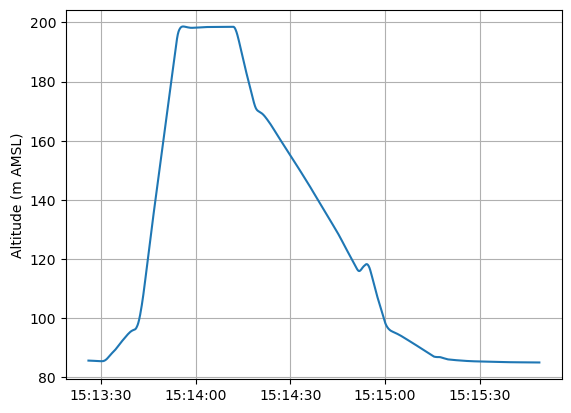

In [9]:
# More readable to extract the desired field from the pandas dataframe first
alt = Influx_DF[Influx_DF['_field'] == 'alt']

# Plot the variable of interest using '_time' and '_value' keys
# This can all be done in one line, but is not as readable to humans
plt.plot(alt['_time'], alt['_value'])
plt.ylabel("Altitude (m AMSL)")
plt.grid()
plt.show()

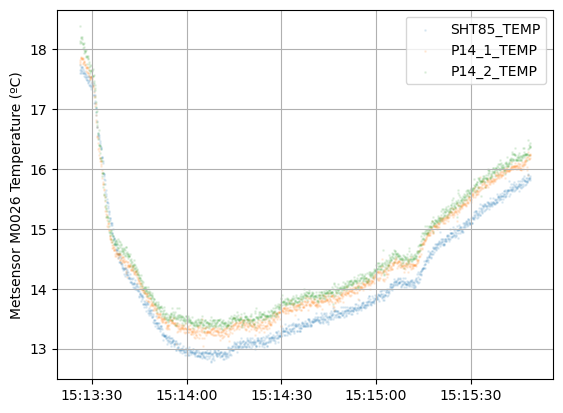

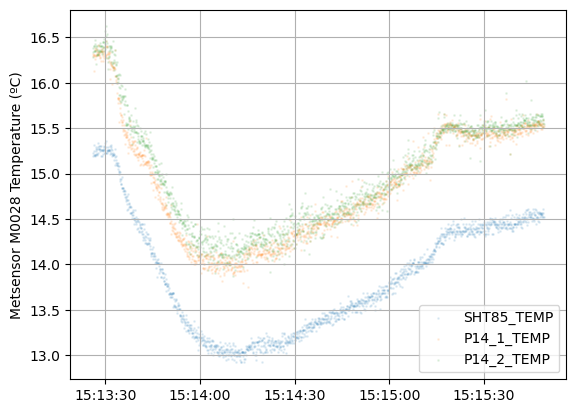

In [10]:
# Metsensor M0026

# More readable to extract the desired field from the pandas dataframe first
# 1) Metsensor ID — one MetSprite carries multiple Metsensors
# 2) Sensor name — Metsensor carries multiple sensor chips
# 3) Field name — each sensor tends to observe multiple variables
SHT85_TEMP = Influx_DF[ (Influx_DF['deviceID'] == 'M0026') & (Influx_DF['sensor'] == 'SHT85') & (Influx_DF['_field'] == 'TEMP') ]
P14_1_TEMP = Influx_DF[ (Influx_DF['deviceID'] == 'M0026') & (Influx_DF['sensor'] == 'P14_1') & (Influx_DF['_field'] == 'TEMP') ]
P14_2_TEMP = Influx_DF[ (Influx_DF['deviceID'] == 'M0026') & (Influx_DF['sensor'] == 'P14_2') & (Influx_DF['_field'] == 'TEMP') ]

# Plot the variable of interest using '_time' and '_value' keys
# This can all be done in one line, but is not as readable to humans
plt.scatter(SHT85_TEMP['_time'], SHT85_TEMP['_value'], label="SHT85_TEMP", alpha=0.1, s=1)
plt.scatter(P14_1_TEMP['_time'], P14_1_TEMP['_value'], label="P14_1_TEMP", alpha=0.1, s=1)
plt.scatter(P14_2_TEMP['_time'], P14_2_TEMP['_value'], label="P14_2_TEMP", alpha=0.1, s=1)
plt.ylabel("Metsensor M0026 Temperature (ºC)")
plt.legend()
plt.grid()
plt.show()



# Metsensor M0028

# More readable to extract the desired field from the pandas dataframe first
# 1) Metsensor ID — one MetSprite carries multiple Metsensors
# 2) Sensor name — Metsensor carries multiple sensor chips
# 3) Field name — each sensor tends to observe multiple variables
SHT85_TEMP = Influx_DF[ (Influx_DF['deviceID'] == 'M0028') & (Influx_DF['sensor'] == 'SHT85') & (Influx_DF['_field'] == 'TEMP') ]
P14_1_TEMP = Influx_DF[ (Influx_DF['deviceID'] == 'M0028') & (Influx_DF['sensor'] == 'P14_1') & (Influx_DF['_field'] == 'TEMP') ]
P14_2_TEMP = Influx_DF[ (Influx_DF['deviceID'] == 'M0028') & (Influx_DF['sensor'] == 'P14_2') & (Influx_DF['_field'] == 'TEMP') ]

# Plot the variable of interest using '_time' and '_value' keys
# This can all be done in one line, but is not as readable to humans
plt.scatter(SHT85_TEMP['_time'], SHT85_TEMP['_value'], label="SHT85_TEMP", alpha=0.1, s=1)
plt.scatter(P14_1_TEMP['_time'], P14_1_TEMP['_value'], label="P14_1_TEMP", alpha=0.1, s=1)
plt.scatter(P14_2_TEMP['_time'], P14_2_TEMP['_value'], label="P14_2_TEMP", alpha=0.1, s=1)
plt.ylabel("Metsensor M0028 Temperature (ºC)")
plt.legend()
plt.grid()
plt.show()